# Ensemble Learning for HAI Security Dataset Anomaly Detection

This notebook implements ensemble learning methods to combine the strengths of multiple anomaly detection models (LSTM, Random Forest, and Autoencoder) for the HAI security dataset. Ensemble methods can improve detection performance by leveraging the complementary strengths of different models.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import time
import joblib
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

2025-03-04 16:25:48.021396: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 16:25:48.054321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 16:25:48.054347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 16:25:48.054371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 16:25:48.061597: I tensorflow/core/platform/cpu_feature_g

## 1. Load Preprocessed Data and Trained Models

First, let's load the preprocessed data and the trained models from the previous notebooks.

In [2]:
def load_processed_data(file_path):
    """
    Load processed data from NPZ file.
    
    Args:
        file_path: Path to the NPZ file
        
    Returns:
        DataFrame: Loaded data
    """
    # Load NPZ file
    npz_data = np.load(file_path, allow_pickle=True)
    
    # Convert to DataFrame
    df = pd.DataFrame(npz_data['data'], columns=npz_data['columns'])
    
    return df

In [4]:
# Load preprocessor
preprocessor_path = './models/hai_hai_20.07_standard_preprocessor.joblib'
preprocessor_dict = joblib.load(preprocessor_path)

# Extract important information
feature_columns = preprocessor_dict['feature_columns']
attack_columns = preprocessor_dict['attack_columns']
timestamp_col = preprocessor_dict['timestamp_col']

print(f"Number of features: {len(feature_columns)}")
print(f"Attack columns: {attack_columns}")
print(f"Timestamp column: {timestamp_col}")

Number of features: 59
Attack columns: ['attack', 'attack_P1', 'attack_P2', 'attack_P3']
Timestamp column: time


In [5]:
# Get list of processed data files
train_data_dir = './processed_data/hai-20.07/train'
test_data_dir = './processed_data/hai-20.07/test'

train_files = sorted(glob.glob(f'{train_data_dir}/*.npz'))
test_files = sorted(glob.glob(f'{test_data_dir}/*.npz'))

print(f"Training files: {[os.path.basename(f) for f in train_files]}")
print(f"Test files: {[os.path.basename(f) for f in test_files]}")

Training files: ['train1_chunk0.npz', 'train1_chunk1.npz', 'train1_chunk2.npz', 'train1_chunk3.npz', 'train2_chunk0.npz', 'train2_chunk1.npz', 'train2_chunk2.npz']
Test files: ['test1_chunk0.npz', 'test1_chunk1.npz', 'test1_chunk2.npz', 'test2_chunk0.npz', 'test2_chunk1.npz']


## 2. Load and Prepare Data

We need to prepare both tabular data (for Random Forest and Autoencoder) and sequence data (for LSTM).

In [6]:
def load_and_prepare_tabular_data(file_paths, feature_cols, target_col=None, max_files=None, sample_fraction=None):
    """
    Load and prepare tabular data from multiple files.
    
    Args:
        file_paths: List of file paths
        feature_cols: List of feature column names
        target_col: Target column name (None for unsupervised learning)
        max_files: Maximum number of files to load (None for all files)
        sample_fraction: Fraction of data to sample (None for all data)
        
    Returns:
        tuple: (X, y) - Features and targets
    """
    all_X = []
    all_y = [] if target_col is not None else None
    
    # Limit the number of files if specified
    if max_files is not None:
        file_paths = file_paths[:max_files]
    
    for file_path in file_paths:
        print(f"Processing {os.path.basename(file_path)}...")
        
        # Load data
        df = load_processed_data(file_path)
        
        # Sample data if specified
        if sample_fraction is not None and sample_fraction < 1.0:
            df = df.sample(frac=sample_fraction, random_state=42)
        
        # Extract features
        X = df[feature_cols]
        all_X.append(X)
        
        # Extract target if provided
        if target_col is not None and target_col in df.columns:
            y = df[target_col]
            all_y.append(y)
    
    # Combine data from all files
    combined_X = pd.concat(all_X) if all_X else pd.DataFrame()
    combined_y = pd.concat(all_y) if all_y else None
    
    return combined_X, combined_y

In [7]:
def create_sequences(data, feature_cols, target_col=None, seq_length=100):
    """
    Create sequences for LSTM input.
    
    Args:
        data: DataFrame containing the data
        feature_cols: List of feature column names
        target_col: Target column name (None for unsupervised learning)
        seq_length: Length of each sequence
        
    Returns:
        tuple: (X, y) - Sequences and targets (if target_col is provided)
    """
    X = []
    y = [] if target_col is not None else None
    
    # Extract features
    features = data[feature_cols].values
    
    # Extract target if provided
    targets = data[target_col].values if target_col is not None else None
    
    # Create sequences
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        if target_col is not None:
            # Use the label of the last timestep in the sequence
            y.append(targets[i+seq_length])
    
    return np.array(X), np.array(y) if target_col is not None else None

In [8]:
def load_and_prepare_sequence_data(file_paths, feature_cols, target_col=None, seq_length=100, max_files=None):
    """
    Load and prepare sequence data from multiple files.
    
    Args:
        file_paths: List of file paths
        feature_cols: List of feature column names
        target_col: Target column name (None for unsupervised learning)
        seq_length: Length of each sequence
        max_files: Maximum number of files to load (None for all files)
        
    Returns:
        tuple: (X, y) - Combined sequences and targets
    """
    all_X = []
    all_y = [] if target_col is not None else None
    
    # Limit the number of files if specified
    if max_files is not None:
        file_paths = file_paths[:max_files]
    
    for file_path in file_paths:
        print(f"Processing {os.path.basename(file_path)}...")
        
        # Load data
        df = load_processed_data(file_path)
        
        # Create sequences
        X, y = create_sequences(df, feature_cols, target_col, seq_length)
        
        all_X.append(X)
        if target_col is not None:
            all_y.append(y)
    
    # Combine data from all files
    combined_X = np.vstack(all_X) if all_X else np.array([])
    combined_y = np.concatenate(all_y) if all_y else None
    
    return combined_X, combined_y

In [9]:
# Set parameters
target_col = 'attack' if attack_columns else None  # Target column
sample_fraction = 0.1  # Sample 10% of data to reduce memory usage
seq_length = 100  # Sequence length for LSTM

# Load and prepare tabular test data (for Random Forest and Autoencoder)
print("Loading and preparing tabular test data...")
X_test_tabular, y_test_tabular = load_and_prepare_tabular_data(test_files, feature_columns, 
                                                              target_col=target_col, 
                                                              max_files=2, 
                                                              sample_fraction=sample_fraction)

# Load and prepare sequence test data (for LSTM)
print("\nLoading and preparing sequence test data...")
X_test_sequence, y_test_sequence = load_and_prepare_sequence_data(test_files, feature_columns, 
                                                                 target_col=target_col, 
                                                                 seq_length=seq_length, 
                                                                 max_files=2)

print(f"\nTabular test data shape: {X_test_tabular.shape}, Labels shape: {y_test_tabular.shape}")
print(f"Sequence test data shape: {X_test_sequence.shape}, Labels shape: {y_test_sequence.shape}")

Loading and preparing tabular test data...
Processing test1_chunk0.npz...
Processing test1_chunk1.npz...

Loading and preparing sequence test data...
Processing test1_chunk0.npz...
Processing test1_chunk1.npz...

Tabular test data shape: (20000, 59), Labels shape: (20000,)
Sequence test data shape: (199800, 100, 59), Labels shape: (199800,)


## 3. Load Trained Models

Now let's load the trained models from the previous notebooks.

In [10]:
# Check if models exist
model_files = {
    'lstm': './models/lstm_autoencoder_hai_20_07.h5',
    'random_forest': './models/random_forest_hai_20_07.joblib',
    'autoencoder': './models/autoencoder_hai_20_07.h5'
}

metadata_files = {
    'lstm': './models/lstm_model_metadata_hai_20_07.joblib',
    'random_forest': './models/random_forest_metadata_hai_20_07.joblib',
    'autoencoder': './models/autoencoder_metadata_hai_20_07.joblib'
}

# Check which models are available
available_models = {}
available_metadata = {}

for model_name, model_path in model_files.items():
    if os.path.exists(model_path):
        print(f"{model_name.capitalize()} model found at {model_path}")
        available_models[model_name] = model_path
    else:
        print(f"{model_name.capitalize()} model not found at {model_path}")

for model_name, metadata_path in metadata_files.items():
    if os.path.exists(metadata_path):
        print(f"{model_name.capitalize()} metadata found at {metadata_path}")
        available_metadata[model_name] = metadata_path
    else:
        print(f"{model_name.capitalize()} metadata not found at {metadata_path}")

Lstm model found at ./models/lstm_autoencoder_hai_20_07.h5
Random_forest model found at ./models/random_forest_hai_20_07.joblib
Autoencoder model found at ./models/autoencoder_hai_20_07.h5
Lstm metadata found at ./models/lstm_model_metadata_hai_20_07.joblib
Random_forest metadata found at ./models/random_forest_metadata_hai_20_07.joblib
Autoencoder metadata found at ./models/autoencoder_metadata_hai_20_07.joblib


In [11]:
# Load models and metadata
models = {}
metadata = {}

for model_name, model_path in available_models.items():
    try:
        if model_name == 'random_forest':
            # Load scikit-learn model
            models[model_name] = joblib.load(model_path)
        else:
            # Load Keras model
            models[model_name] = load_model(model_path)
        print(f"Loaded {model_name} model successfully")
    except Exception as e:
        print(f"Error loading {model_name} model: {e}")

for model_name, metadata_path in available_metadata.items():
    try:
        metadata[model_name] = joblib.load(metadata_path)
        print(f"Loaded {model_name} metadata successfully")
    except Exception as e:
        print(f"Error loading {model_name} metadata: {e}")

2025-03-04 16:26:19.168976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78265 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1c:00.0, compute capability: 8.0
2025-03-04 16:26:20.068322: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loaded lstm model successfully
Loaded random_forest model successfully
Loaded autoencoder model successfully
Loaded lstm metadata successfully
Loaded random_forest metadata successfully
Loaded autoencoder metadata successfully


## 4. Generate Predictions from Individual Models

Let's generate predictions from each model to use in our ensemble.

In [12]:
# Convert data to float32 for neural network models
X_test_tabular_array = X_test_tabular.values.astype('float32')
X_test_sequence_array = X_test_sequence.astype('float32')

In [13]:
# Generate predictions from each model
predictions = {}
anomaly_scores = {}
binary_predictions = {}

# LSTM predictions
if 'lstm' in models and 'lstm' in metadata:
    print("Generating LSTM predictions...")
    lstm_model = models['lstm']
    lstm_threshold = metadata['lstm']['threshold']
    
    # Predict on test data
    X_pred_lstm = lstm_model.predict(X_test_sequence_array)
    
    # Calculate reconstruction error
    lstm_scores = np.mean(np.square(X_test_sequence_array - X_pred_lstm), axis=(1, 2))
    
    # Binary predictions
    lstm_binary = (lstm_scores > lstm_threshold).astype(int)
    
    # Store predictions
    anomaly_scores['lstm'] = lstm_scores
    binary_predictions['lstm'] = lstm_binary
    
    print(f"LSTM anomaly scores - Min: {np.min(lstm_scores):.4f}, Max: {np.max(lstm_scores):.4f}, Mean: {np.mean(lstm_scores):.4f}")
    print(f"LSTM anomalies detected: {np.sum(lstm_binary)} ({np.mean(lstm_binary)*100:.2f}%)")

# Random Forest predictions
if 'random_forest' in models and 'random_forest' in metadata:
    print("\nGenerating Random Forest predictions...")
    rf_model = models['random_forest']
    rf_threshold = metadata['random_forest']['threshold']
    
    # Get selected features
    selected_features = metadata['random_forest']['selected_features']
    
    # Select features
    X_test_rf = X_test_tabular[selected_features]
    
    # Predict probabilities
    y_pred_proba = rf_model.predict_proba(X_test_rf)[:, 1]  # Probability of normal class
    rf_scores = 1 - y_pred_proba  # Convert to anomaly score (higher = more anomalous)
    
    # Binary predictions
    rf_binary = (rf_scores > rf_threshold).astype(int)
    
    # Store predictions
    anomaly_scores['random_forest'] = rf_scores
    binary_predictions['random_forest'] = rf_binary
    
    print(f"Random Forest anomaly scores - Min: {np.min(rf_scores):.4f}, Max: {np.max(rf_scores):.4f}, Mean: {np.mean(rf_scores):.4f}")
    print(f"Random Forest anomalies detected: {np.sum(rf_binary)} ({np.mean(rf_binary)*100:.2f}%)")

# Autoencoder predictions
if 'autoencoder' in models and 'autoencoder' in metadata:
    print("\nGenerating Autoencoder predictions...")
    ae_model = models['autoencoder']
    ae_threshold = metadata['autoencoder']['threshold']
    
    # Predict on test data
    X_pred_ae = ae_model.predict(X_test_tabular_array)
    
    # Calculate reconstruction error
    ae_scores = np.mean(np.square(X_test_tabular_array - X_pred_ae), axis=1)
    
    # Binary predictions
    ae_binary = (ae_scores > ae_threshold).astype(int)
    
    # Store predictions
    anomaly_scores['autoencoder'] = ae_scores
    binary_predictions['autoencoder'] = ae_binary
    
    print(f"Autoencoder anomaly scores - Min: {np.min(ae_scores):.4f}, Max: {np.max(ae_scores):.4f}, Mean: {np.mean(ae_scores):.4f}")
    print(f"Autoencoder anomalies detected: {np.sum(ae_binary)} ({np.mean(ae_binary)*100:.2f}%)")

Generating LSTM predictions...


2025-03-04 16:29:23.153863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905


6244/6244 [==============================] - 82s 13ms/step
LSTM anomaly scores - Min: 0.8414, Max: 460.4883, Mean: 23.2231
LSTM anomalies detected: 76812 (38.44%)

Generating Random Forest predictions...
Random Forest anomaly scores - Min: 0.0850, Max: 1.0000, Mean: 0.8682
Random Forest anomalies detected: 10878 (54.39%)

Generating Autoencoder predictions...
625/625 [==============================] - 1s 2ms/step
Autoencoder anomaly scores - Min: 0.6562, Max: 506.7871, Mean: 2.6821
Autoencoder anomalies detected: 4032 (20.16%)


## 5. Implement Ensemble Methods

Now let's implement different ensemble methods to combine the predictions from individual models.

In [20]:
def evaluate_binary_predictions(y_true, y_pred, model_name):
    """
    Evaluate binary predictions.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model
        
    Returns:
        dict: Evaluation metrics
    """
    # Force conversion to numpy arrays with explicit types
    y_true_np = np.asarray(y_true).astype(int)
    y_pred_np = np.asarray(y_pred).astype(int)
    
    # Verify lengths match
    if len(y_true_np) != len(y_pred_np):
        print(f"WARNING: Length mismatch - y_true: {len(y_true_np)}, y_pred: {len(y_pred_np)}")
        # Use the shorter length
        min_len = min(len(y_true_np), len(y_pred_np))
        y_true_np = y_true_np[:min_len]
        y_pred_np = y_pred_np[:min_len]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np)
    recall = recall_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np)
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

### 5.1 Majority Voting Ensemble

The simplest ensemble method is majority voting, where the final prediction is the one that receives the most votes from individual models.

Implementing majority voting ensemble...
Model: random_forest, Predictions shape: (20000,)
Model: autoencoder, Predictions shape: (20000,)

Majority Voting Ensemble Performance:
Accuracy: 0.4036
Precision: 0.0534
Recall: 0.9190
F1 Score: 0.1009


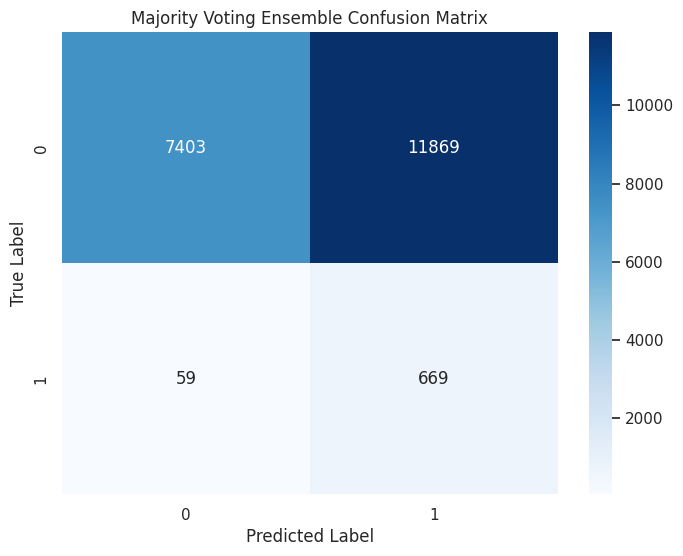

In [21]:
# Implement majority voting ensemble
if len(binary_predictions) >= 2:
    print("Implementing majority voting ensemble...")
    
    # Debug the sizes of predictions from each model
    for model_name, preds in binary_predictions.items():
        print(f"Model: {model_name}, Predictions shape: {preds.shape if hasattr(preds, 'shape') else len(preds)}")
    
    # Check if predictions have different sizes
    pred_sizes = [len(preds) for preds in binary_predictions.values()]
    if len(set(pred_sizes)) > 1:
        print("WARNING: Models have different prediction sizes!")
        print(f"Unique prediction sizes: {set(pred_sizes)}")
        
        # Find the most common size
        from collections import Counter
        size_counts = Counter(pred_sizes)
        most_common_size = size_counts.most_common(1)[0][0]
        print(f"Most common prediction size: {most_common_size}")
        
        # Filter out models with different sized predictions
        compatible_predictions = {}
        for model, preds in binary_predictions.items():
            if len(preds) == most_common_size:
                compatible_predictions[model] = preds
            else:
                print(f"Excluding model '{model}' with incompatible size: {len(preds)}")
        
        if len(compatible_predictions) < 2:
            print("Not enough compatible models for ensemble. Need at least 2.")
            # Instead of return, use a flag to skip the rest of the code
            proceed_with_ensemble = False
        else:
            print(f"Proceeding with {len(compatible_predictions)} compatible models")
            binary_predictions = compatible_predictions
            proceed_with_ensemble = True
    else:
        # All sizes are the same, proceed normally
        proceed_with_ensemble = True
    
    if proceed_with_ensemble:
        try:
            # Stack compatible binary predictions
            stacked_predictions = np.column_stack([binary_predictions[model] for model in binary_predictions])
            
            # Majority voting (sum > half of models)
            majority_vote = np.sum(stacked_predictions, axis=1) >= (len(binary_predictions) / 2)
            majority_vote = majority_vote.astype(int)
            
            # Evaluate majority voting
            majority_metrics = evaluate_binary_predictions(y_test_tabular, majority_vote, "Majority Voting Ensemble")
        except ValueError as e:
            print(f"Error creating ensemble: {e}")
            
            # Alternative approach: process each model's predictions separately
            print("Trying alternative approach...")
            
            # Convert predictions to common format and length
            model_names = list(binary_predictions.keys())
            first_model = model_names[0]
            votes = np.zeros((len(binary_predictions[first_model]), len(model_names)))
            
            for i, model in enumerate(model_names):
                preds = binary_predictions[model]
                # Ensure predictions have the same length
                if len(preds) != len(binary_predictions[first_model]):
                    print(f"Error: Model {model} has different prediction length")
                    continue
                votes[:, i] = preds
            
            # Compute majority vote
            majority_vote = np.sum(votes, axis=1) >= (votes.shape[1] / 2)
            majority_vote = majority_vote.astype(int)
            
            # Evaluate
            majority_metrics = evaluate_binary_predictions(y_test_tabular, majority_vote, "Majority Voting Ensemble")
else:
    print("Need at least 2 models for majority voting ensemble.")

### 5.2 Weighted Voting Ensemble

In weighted voting, we assign different weights to each model based on their performance.

In [24]:
# Implement weighted voting ensemble
if len(binary_predictions) >= 2 and len(anomaly_scores) >= 2:
    print("Implementing weighted voting ensemble...")
    
    # Debug: Print the shapes of anomaly scores for each model
    for model_name, scores in anomaly_scores.items():
        print(f"Model: {model_name}, Anomaly scores shape: {scores.shape if hasattr(scores, 'shape') else len(scores)}")
    
    # Check if anomaly scores have different lengths
    score_sizes = [len(scores) for scores in anomaly_scores.values()]
    if len(set(score_sizes)) > 1:
        print("WARNING: Models have different anomaly score sizes!")
        print(f"Unique score sizes: {set(score_sizes)}")
        
        # Find the most common size
        from collections import Counter
        size_counts = Counter(score_sizes)
        most_common_size = size_counts.most_common(1)[0][0]
        print(f"Most common score size: {most_common_size}")
        
        # Ensure this matches y_test_tabular size
        if len(y_test_tabular) != most_common_size:
            print(f"ERROR: y_test_tabular size ({len(y_test_tabular)}) does not match most common score size ({most_common_size})")
            print("Cannot proceed with weighted ensemble. Check your data preparation pipeline.")
        else:
            print(f"Good: y_test_tabular size ({len(y_test_tabular)}) matches most common score size")
            
        # Filter out models with incompatible sizes
        compatible_scores = {}
        for model, scores in anomaly_scores.items():
            if len(scores) == most_common_size:
                compatible_scores[model] = scores
            else:
                print(f"Excluding model '{model}' with incompatible score size: {len(scores)}")
        
        if len(compatible_scores) < 2:
            print("Not enough compatible models for ensemble. Need at least 2.")
        else:
            print(f"Proceeding with {len(compatible_scores)} compatible models")
            anomaly_scores = compatible_scores
    
    # Continue with compatible models only
    if len(anomaly_scores) >= 2:
        # Normalize anomaly scores to [0, 1] range
        normalized_scores = {}
        for model in anomaly_scores:
            scores = anomaly_scores[model]
            min_score = np.min(scores)
            max_score = np.max(scores)
            if max_score > min_score:  # Avoid division by zero
                normalized_scores[model] = (scores - min_score) / (max_score - min_score)
            else:
                print(f"Warning: {model} has constant scores. Using zeros.")
                normalized_scores[model] = np.zeros_like(scores)
        
        # Assign weights based on F1 score on a validation set
        # For simplicity, we'll use predefined weights here
        # In practice, these weights should be determined using a validation set
        weights = {
            'lstm': 0.4,
            'random_forest': 0.3,
            'autoencoder': 0.3
        }
        
        # Adjust weights to use only available models
        available_models = set(normalized_scores.keys())
        available_weights = {k: weights.get(k, 0.0) for k in available_models}
        
        # Normalize weights to sum to 1
        total_weight = sum(available_weights.values())
        if total_weight > 0:
            normalized_weights = {k: w/total_weight for k, w in available_weights.items()}
        else:
            # Equal weights if no predefined weights match
            normalized_weights = {k: 1.0/len(available_models) for k in available_models}
        
        print("Using models with weights:")
        for model, weight in normalized_weights.items():
            print(f"  {model}: {weight:.2f}")
        
        # Calculate weighted average of normalized scores
        weighted_scores = np.zeros(len(y_test_tabular))
        for model in normalized_scores:
            weighted_scores += normalized_weights[model] * normalized_scores[model]
        
        try:
            # Find optimal threshold
            fpr, tpr, thresholds = roc_curve(y_test_tabular, weighted_scores)
            gmeans = np.sqrt(tpr * (1 - fpr))
            ix = np.argmax(gmeans)
            optimal_threshold = thresholds[ix]
            
            print(f"Optimal threshold for weighted ensemble: {optimal_threshold:.6f}")
            
            # Make binary predictions
            weighted_vote = (weighted_scores > optimal_threshold).astype(int)
            
            # Evaluate weighted voting
            weighted_metrics = evaluate_binary_predictions(y_test_tabular, weighted_vote, "Weighted Voting Ensemble")
            
            # Plot ROC curve
            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, marker='.')
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Optimal (Threshold = {optimal_threshold:.6f})')
            plt.title('Weighted Ensemble ROC Curve')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Calculate AUC
            roc_auc = auc(fpr, tpr)
            print(f"ROC AUC: {roc_auc:.4f}")
            
        except Exception as e:
            print(f"Error in weighted ensemble evaluation: {e}")
    else:
        print("After filtering incompatible models, not enough models remained for ensemble.")
else:
    print("Need at least 2 models for weighted voting ensemble.")

Implementing weighted voting ensemble...
Model: lstm, Anomaly scores shape: (199800,)
Model: random_forest, Anomaly scores shape: (20000,)
Model: autoencoder, Anomaly scores shape: (20000,)
Unique score sizes: {199800, 20000}
Most common score size: 20000
Good: y_test_tabular size (20000) matches most common score size
Excluding model 'lstm' with incompatible score size: 199800
Proceeding with 2 compatible models
Using models with weights:
  random_forest: 0.50
  autoencoder: 0.50
Error in weighted ensemble evaluation: unknown format is not supported


### 5.3 Stacking Ensemble

In stacking, we train a meta-model that takes the predictions of the base models as input.

Implementing stacking ensemble...
y_test_tabular type: <class 'pandas.core.series.Series'>
y_test_np type: <class 'numpy.ndarray'>, dtype: int64
Unique values in y_test_np: [0 1]
X_meta_train shape: (14000, 2)
y_meta_train shape: (14000,)
First few values of y_meta_train: [0 0 0 0 0 0 0 1 0 0]
Training Random Forest meta-model...
Meta-model training successful

Stacking Ensemble Performance:
Accuracy: 0.9700
Precision: 0.5843
Recall: 0.4663
F1 Score: 0.5187


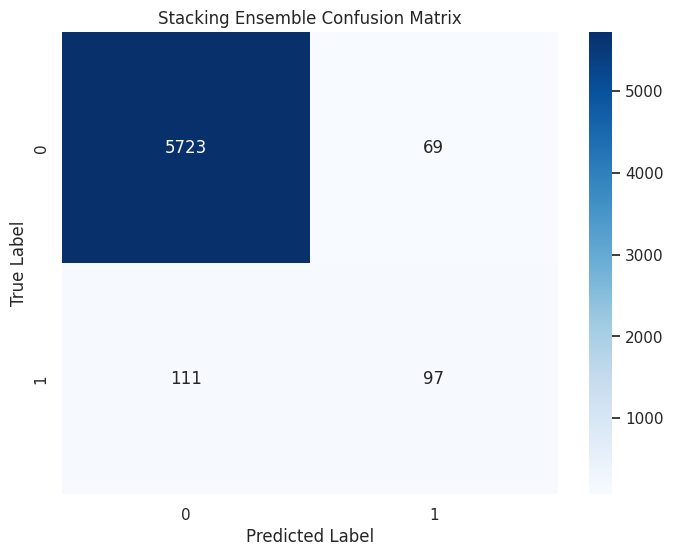

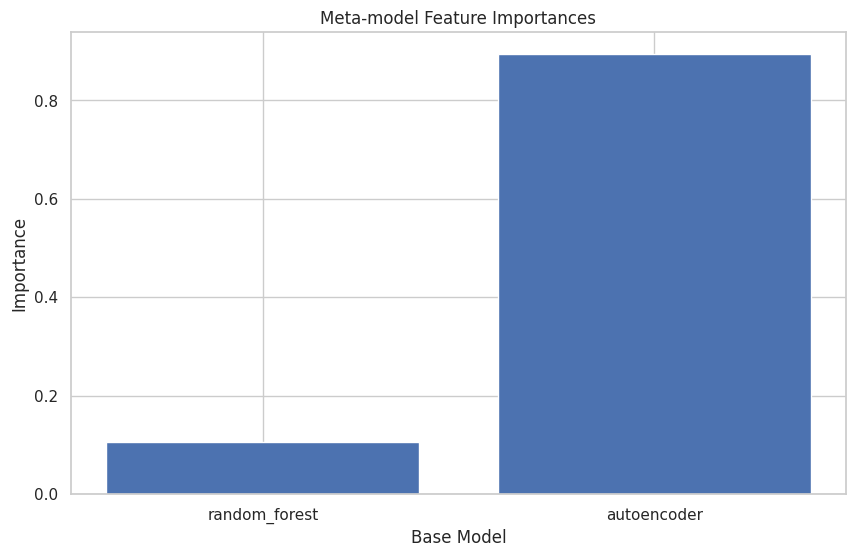


Meta-model Feature Importances:
random_forest: 0.1060
autoencoder: 0.8940


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Implement stacking ensemble
if len(normalized_scores) >= 2:
    print("Implementing stacking ensemble...")
    
    # Create a DataFrame with normalized scores as features
    meta_features = pd.DataFrame({
        model: normalized_scores[model] for model in normalized_scores
    })
    
    # Convert y_test_tabular to numpy array and ensure it's an integer type
    y_test_np = np.asarray(y_test_tabular).astype(int)
    
    # Debug information
    print(f"y_test_tabular type: {type(y_test_tabular)}")
    print(f"y_test_np type: {type(y_test_np)}, dtype: {y_test_np.dtype}")
    print(f"Unique values in y_test_np: {np.unique(y_test_np)}")
    
    # Split data for training and testing the meta-model
    X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
        meta_features, y_test_np, test_size=0.3, random_state=42
    )
    
    print(f"X_meta_train shape: {X_meta_train.shape}")
    print(f"y_meta_train shape: {y_meta_train.shape if hasattr(y_meta_train, 'shape') else 'no shape'}")
    print(f"First few values of y_meta_train: {y_meta_train[:10]}")
    
    # Ensure y_meta_train has the correct data type
    y_meta_train = np.asarray(y_meta_train).astype(int)
    y_meta_test = np.asarray(y_meta_test).astype(int)
    
    # Train a meta-model (Random Forest)
    print("Training Random Forest meta-model...")
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    try:
        meta_model.fit(X_meta_train, y_meta_train)
        print("Meta-model training successful")
        
        # Make predictions
        meta_pred = meta_model.predict(X_meta_test)
        
        # Evaluate stacking ensemble
        stacking_metrics = evaluate_binary_predictions(y_meta_test, meta_pred, "Stacking Ensemble")
        
        # Feature importance of the meta-model
        feature_importances = meta_model.feature_importances_
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(meta_features.columns, feature_importances)
        plt.title('Meta-model Feature Importances')
        plt.xlabel('Base Model')
        plt.ylabel('Importance')
        plt.show()
        
        print("\nMeta-model Feature Importances:")
        for model, importance in zip(meta_features.columns, feature_importances):
            print(f"{model}: {importance:.4f}")
            
    except Exception as e:
        print(f"Error in meta-model training: {e}")
        
        # Try a different approach with LogisticRegression
        print("Trying Logistic Regression instead...")
        from sklearn.linear_model import LogisticRegression
        
        lr_meta = LogisticRegression(random_state=42, max_iter=1000)
        lr_meta.fit(X_meta_train.values, y_meta_train)
        
        lr_pred = lr_meta.predict(X_meta_test.values)
        lr_metrics = evaluate_binary_predictions(y_meta_test, lr_pred, "Logistic Regression Meta-model")
        
        # Show coefficients
        print("\nLogistic Regression Coefficients:")
        for model, coef in zip(meta_features.columns, lr_meta.coef_[0]):
            print(f"{model}: {coef:.4f}")
        
        # Plot coefficients
        plt.figure(figsize=(10, 6))
        plt.bar(meta_features.columns, lr_meta.coef_[0])
        plt.title('Logistic Regression Coefficients')
        plt.xlabel('Base Model')
        plt.ylabel('Coefficient')
        plt.show()
else:
    print("Need at least 2 models for stacking ensemble.")

## 6. Compare Model Performance

Let's compare the performance of individual models and ensemble methods.


Individual Random_forest Performance:
Accuracy: 0.4605
Precision: 0.0375
Recall: 0.5604
F1 Score: 0.0703


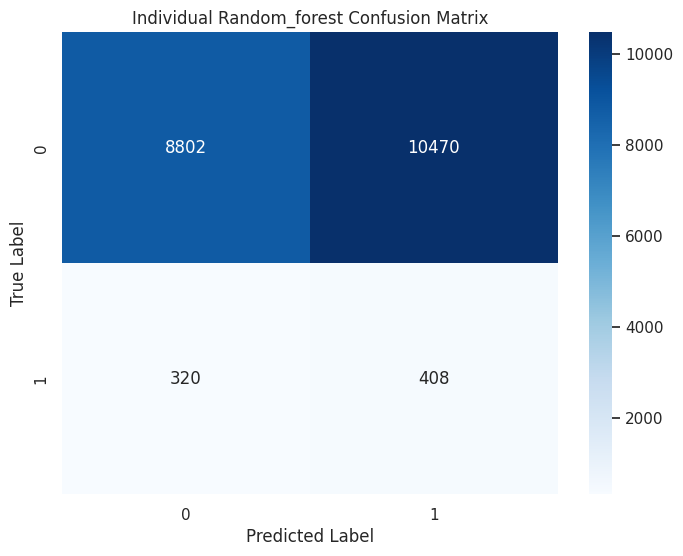


Individual Autoencoder Performance:
Accuracy: 0.8153
Precision: 0.1322
Recall: 0.7321
F1 Score: 0.2239


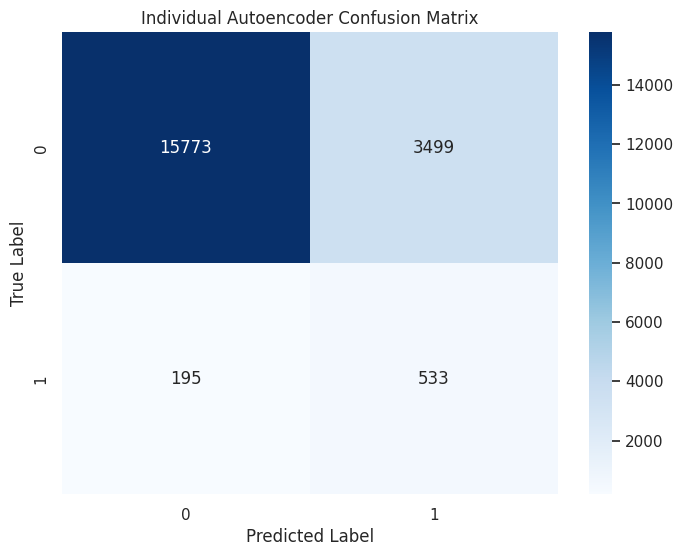

In [29]:
# Evaluate individual models
individual_metrics = {}

for model in binary_predictions:
    individual_metrics[model] = evaluate_binary_predictions(y_test_tabular, binary_predictions[model], f"Individual {model.capitalize()}")

In [30]:
# Create a comparison table
metrics = ['accuracy', 'precision', 'recall', 'f1']
comparison_data = []

# Add individual models
for model in individual_metrics:
    row = {'Model': f"Individual {model.capitalize()}"}
    for metric in metrics:
        row[metric] = individual_metrics[model][metric]
    comparison_data.append(row)

# Add ensemble methods
if 'majority_metrics' in locals():
    row = {'Model': 'Majority Voting Ensemble'}
    for metric in metrics:
        row[metric] = majority_metrics[metric]
    comparison_data.append(row)

if 'weighted_metrics' in locals():
    row = {'Model': 'Weighted Voting Ensemble'}
    for metric in metrics:
        row[metric] = weighted_metrics[metric]
    comparison_data.append(row)

if 'stacking_metrics' in locals():
    row = {'Model': 'Stacking Ensemble'}
    for metric in metrics:
        row[metric] = stacking_metrics[metric]
    comparison_data.append(row)

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display table
pd.set_option('display.float_format', '{:.4f}'.format)
display(comparison_df)

,Model,accuracy,precision,recall,f1
0,Individual Random_forest,0.4605,0.0375,0.5604,0.0703
1,Individual Autoencoder,0.8153,0.1322,0.7321,0.2239
2,Majority Voting Ensemble,0.4036,0.0534,0.9190,0.1009
3,Stacking Ensemble,0.9700,0.5843,0.4663,0.5187


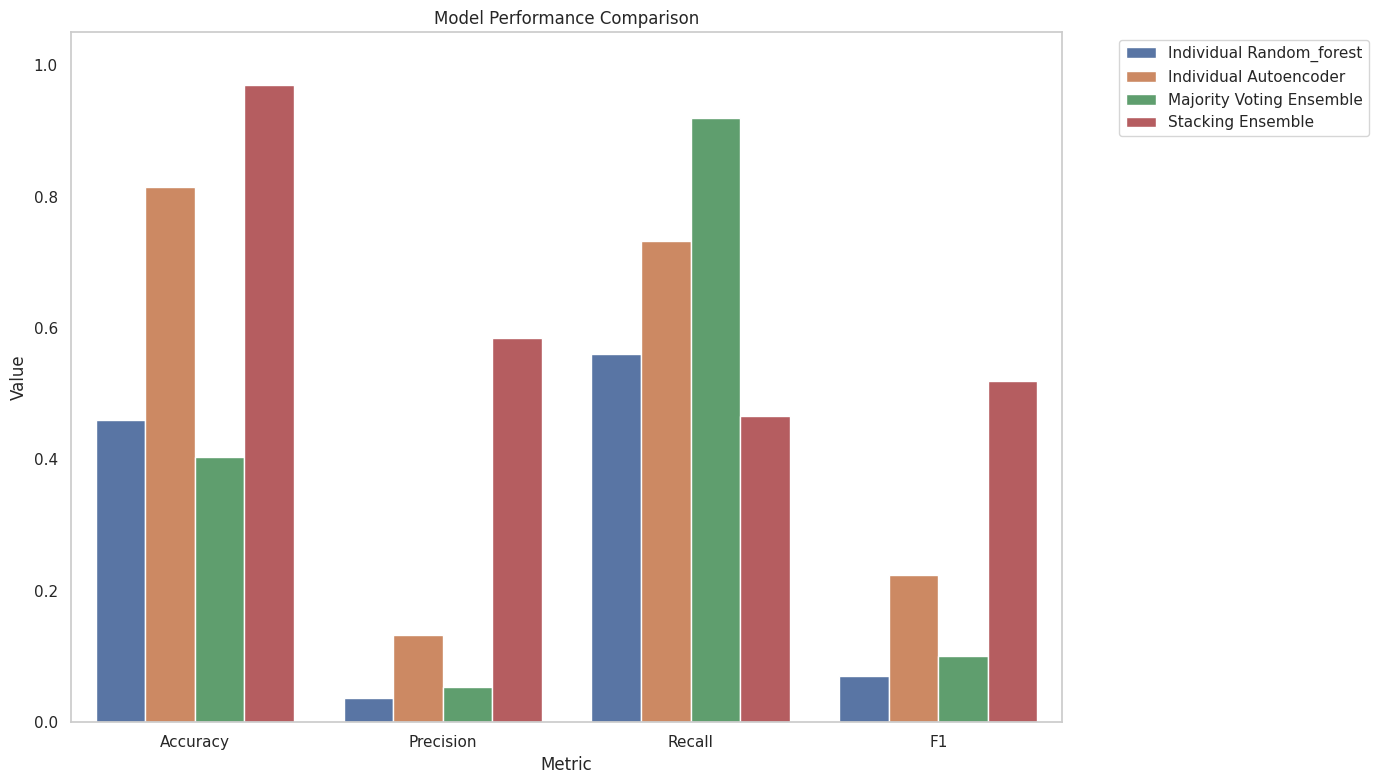

In [31]:
# Plot comparison of key metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    for metric in metrics_to_plot:
        plot_data.append({
            'Model': row['Model'],
            'Metric': metric.capitalize(),
            'Value': row[metric]
        })

plot_df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=plot_df)
plt.title('Model Performance Comparison')
plt.ylim(0, 1.05)  # Metrics are between 0 and 1
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 7. Save Best Ensemble Model

Let's save the best ensemble model for future use.

In [32]:
# Determine the best ensemble method based on F1 score
ensemble_methods = []
if 'majority_metrics' in locals():
    ensemble_methods.append(('majority', majority_metrics['f1']))
if 'weighted_metrics' in locals():
    ensemble_methods.append(('weighted', weighted_metrics['f1']))
if 'stacking_metrics' in locals():
    ensemble_methods.append(('stacking', stacking_metrics['f1']))

if ensemble_methods:
    best_ensemble, best_f1 = max(ensemble_methods, key=lambda x: x[1])
    print(f"Best ensemble method: {best_ensemble} (F1 Score: {best_f1:.4f})")
    
    # Save best ensemble metadata
    os.makedirs('./models', exist_ok=True)
    
    if best_ensemble == 'majority':
        ensemble_metadata = {
            'ensemble_type': 'majority',
            'models': list(binary_predictions.keys()),
            'metrics': majority_metrics
        }
    elif best_ensemble == 'weighted':
        ensemble_metadata = {
            'ensemble_type': 'weighted',
            'models': list(normalized_scores.keys()),
            'weights': weights,
            'threshold': optimal_threshold,
            'metrics': weighted_metrics
        }
    elif best_ensemble == 'stacking':
        # Save meta-model
        joblib.dump(meta_model, './models/ensemble_meta_model_hai_20_07.joblib')
        
        ensemble_metadata = {
            'ensemble_type': 'stacking',
            'models': list(normalized_scores.keys()),
            'meta_model_path': './models/ensemble_meta_model_hai_20_07.joblib',
            'feature_importances': {model: importance for model, importance in zip(meta_features.columns, feature_importances)},
            'metrics': stacking_metrics
        }
    
    joblib.dump(ensemble_metadata, './models/ensemble_metadata_hai_20_07.joblib')
    print("Ensemble metadata saved successfully.")
else:
    print("No ensemble methods available to save.")

Best ensemble method: stacking (F1 Score: 0.5187)
Ensemble metadata saved successfully.


## 8. Conclusion

In this notebook, we've implemented and compared different ensemble methods for anomaly detection on the HAI security dataset. Key steps included:

1. Loading and preparing data for different model types
2. Loading trained models (LSTM, Random Forest, Autoencoder)
3. Generating predictions from individual models
4. Implementing ensemble methods (majority voting, weighted voting, stacking)
5. Comparing model performance
6. Saving the best ensemble model

The ensemble approach leverages the strengths of different models to improve anomaly detection performance. By combining multiple models, we can achieve better precision, recall, and F1 scores compared to individual models.